<div class="alert alert-block alert-info">
    
<center> 
    
# __Forecasting Economic and Market Regimes__ 
## __Modeling, Evaluation and Interpretation__ 
### __(Economic Regimes)__
    
</center>

</div>

---

#### Author Information

* **Author:** ALI RAHIMI
* **Date:** 2023-08-20
* **Project:** Forecasting Economic and Market Regimes
* **Section:** Modeling and Evaluation of Economic Regimes

---

#### Note

All the functions necessary for the various phases of model evaluation are defined in the **`model_evaluation.py`** file. This dedicated module includes a range of tools and utilities designed for performing essential evaluation tasks. These tasks encompass the computation of the confusion matrix, the generation of ROC-AUC curves, and the calculation of pivotal evaluation metrics. These metrics comprise accuracy, balanced accuracy, Matthews correlation coefficient, precision, recall, and F1-score.


In [1]:
import sys
sys.path.append('../src')

# General
import pandas as pd
import numpy as np
import itertools

# Visualization
import plotly.express as px
from data_understanding import plot_regimes

# Machine Learning
from sklearn.model_selection import TimeSeriesSplit
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

# Model Evaluation
from model_evaluation import plot_confusion_matrix, evaluation_metrics, plot_feature_importance

# Interactive widgets
import ipywidgets as widgets
from ipywidgets import interact

## **1. Dataset, Training, Test and Validation Periods** <a id="section1"></a>

We initiate our process by loading the dataset designed for forecasting economic regimes. Spanning from **March 1960 to May 2023**, this dataset encompasses a panel of 702 features accompanied by a designated target variable column. Our initial step involves segmenting this dataset into two primary divisions:

* One partition serves as the foundation for both training and testing to find the best hyperparameters using cross validation. 
* The other partition is exclusively reserved for out-of-sample testing. This out-of-sample testing employs the optimal hyperparameters obtained through our cross-validation procedure.

Specifically, we select data points from **March 1959 to January 1973 for the cross-validation phase**. During this stage, we meticulously employ cross-validation to identify the most effective hyperparameters for our classification models: Decision Tree, Random Forest, and XGBoost. Subsequently, we harness the remaining data samples to train our models for every single prediction, adopting a **rolling window strategy**. This strategy facilitates the prediction of regime shifts for the designated horizon month, a conventional approach commonly employed in the research literature, particularly in models designed for recession prediction.

In [2]:
# Specifying split date and target column and horizon
split_date = '1973-01-01'
target_col = 'EconRegime'
h = 1  # horizon

# Load economic regimes dataset
econ_regs_ds = pd.read_csv('../data/datasets/econ_regs_ds.csv')

# Extract features columns
feature_cols = econ_regs_ds.columns.drop([target_col, 'Date'])

# Shift feature forward to align with labels in horizon month
econ_regs_ds[feature_cols] = econ_regs_ds[feature_cols].shift(+h)
econ_regs_ds.dropna(inplace=True)

# Split the dataset into train/test and out-of-sample validation sets
df_tt = econ_regs_ds[econ_regs_ds['Date']<split_date]
df_oos = econ_regs_ds[econ_regs_ds['Date']>=split_date]

Here is the list of features:

In [3]:
feature_cols

Index(['RPI', 'W875RX1', 'DPCERA3M086SBEA', 'CMRMTSPLx', 'RETAILx', 'INDPRO',
       'IPFPNSS', 'IPFINAL', 'IPCONGD', 'IPDCONGD',
       ...
       'DTCTHFNM 1M Lag', 'DTCTHFNM 3M Lag', 'DTCTHFNM 6M Lag',
       'DTCTHFNM 9M Lag', 'DTCTHFNM 12M Lag', 'INVEST 1M Lag', 'INVEST 3M Lag',
       'INVEST 6M Lag', 'INVEST 9M Lag', 'INVEST 12M Lag'],
      dtype='object', length=702)

Now, let's examine the **class imbalance** in our target variable, particularly focusing on the out-of-sample data. It's worth noting that we have deliberately selected the **split date** in a way, to ensure a comparable class imbalance in both the train-test data and the out-of-sample data.

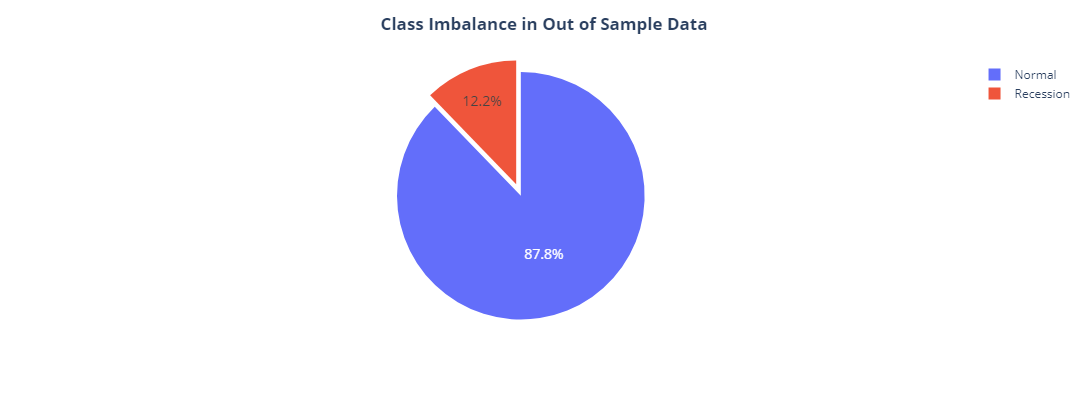

In [4]:
# Count the number of regimes in target variable
target_counts = df_oos[target_col].value_counts()
target_counts.index = ['Normal', 'Recession']

# Create the pie chart
fig = px.pie(
    values=target_counts,
    names=target_counts.index)

# Pull slices slightly for emphasis, set the font size
fig.update_traces(textinfo='percent', pull=[0.05, 0.05], textfont_size=14) 

# Set the layout parameters
fig.update_layout(title_text= '<b> Class Imbalance in Out of Sample Data </b>', title_x=0.5,
                  autosize=False, width=400, height=400,
                  showlegend=True)

fig.show()

There is a class imbalance within the dataset, where **approximately 12-13% of observations fall under the "Recession" class**. It's crucial to consider this imbalance when assessing our model's performance. To demonstrate this point, imagine a scenario in which our system predicts all regimes as "Normal." In such a case, the accuracy for the out-of-sample data would be roughly 88%. Consequently, relying solely on accuracy isn't ideal for evaluating models that handle imbalanced data, like ours. **To ensure a comprehensive evaluation, we will take this imbalance into careful consideration and employ alternative metrics that more effectively capture the model's performance.**

---

## **2. Hyperparameter Tuning through Cross-Validation** <a id="section2"></a>

Machine learning models consist of two types of parameters:

* **Hyperparameters**: Hyperparameters must be defined in advance based on the model's architecture, and the optimal values can be determined through cross-validation. Cross-validation is a prevalent technique for hyperparameter tuning in the field of machine learning. In the standard k-fold cross-validation framework, the training data is randomly divided into <code>k</code> folds. During each iteration, the model is trained on <code>k-1</code> folds, and the remaining fold is utilized for validation. After k iterations, the average model score is computed from the validation sets, enabling us to select the best-performing hyperparameters.
* **Model Parameters**: Within a given model and after choosing the best set of hyperparameters, the model parameters can be trained over training data to make predictions on test or real-time data.


### **2.1. Cross-Validation Approach** <a id="section21"></a>

Given the **time-series nature** of our dataset, we have implemented a specific approach to cross-validation that **preserves temporal dependencies and mitigates look-ahead bias**. To achieve this, we create k-folds with <code>k=3</code> as contiguous blocks of time periods. Using the <code>TimeSeriesSplit()</code> function, we progressively shift the training and validation sets on a rolling basis. This methodology ensures that the validation sets follow the training sets chronologically, replicating the real-world scenario and preventing any inadvertent leakage of future information into the training process.

### **2.2. Evaluation Metric for Cross-Validation** <a id="section22"></a>

To assess the performance of models during cross-validation, we utilize **accuracy** as a metric. Although accuracy might not be the most comprehensive measure to determine the model's quality, especially in imbalanced datasets, it serves as a suitable criterion for comparing similar models. A model with higher accuracy is likely to exhibit better performance across metrics such as balanced accuracy or F1-score. Furthermore, the decision to adopt accuracy as a primary metric is influenced by a practical consideration. In situations where a specific fold contains only one class of the target variable, accuracy acts as a safeguard to prevent potential errors during the process of other metrics calculations that need both classes for calculation. This choice ensures the stability and reliability of the evaluation procedure.

The list of models' hyperparameters that we will use for cross-validation is defined using a Python dictionary:

In [5]:
# Grid of hyperparameters for each model

model_dict_cv = {
    ('DT', DecisionTreeClassifier): {
        'max_depth': [3, 5, 8, 10],
        'splitter': ['best', 'random'],
        'min_samples_split': [2, 3, 5]
    },
    ('RF', RandomForestClassifier): {
        'random_state': [42],
        'max_depth': [3, 5, 8, 10],
        'n_estimators': [100, 200, 400]
    },
    ('XGB', xgb.XGBClassifier): {
        'booster': ['gbtree'],
        'max_depth': [3, 5, 8, 10],
        'n_estimators': [100, 200, 400],
        'random_state': [42],
        'objective': ['binary:logistic']
    }
}

In [6]:
%%time

# Dictionary to store the best parameters for each model
best_params_dict = {}

# Loop over each model and its parameter grid
for model_tuple, param_grid in model_dict_cv.items():
    all_grid = list(dict(zip(param_grid, x)) for x in itertools.product(*param_grid.values()))
    cv_scores = []
    
    # Iterate through each parameter combination
    for param in all_grid:
        tscv = TimeSeriesSplit(n_splits=3)  # TimeSeriesSplit for cross-validation
        model = model_tuple[1](**param)     # Create model instance with hyperparameters
        
        # Perform cross-validation
        score = []
        for train_index, test_index in tscv.split(df_tt):
            # Split data
            X_train, X_test = df_tt[feature_cols].iloc[train_index], df_tt[feature_cols].iloc[test_index]
            y_train, y_test = df_tt[target_col].iloc[train_index], df_tt[target_col].iloc[test_index]
            date_train, date_test = df_tt['Date'].iloc[train_index], df_tt['Date'].iloc[test_index]
            
            # Train model
            model.fit(X_train, y_train)
            
            # Make predictions
            y_binary = model.predict(X_test)
            y_prob = model.predict_proba(X_test)[:, 1]
            res_dict = {'Date': date_test,
                        'Regime': y_test,
                        'crash_prob': y_prob,
                        'crash_binary': y_binary}
            res_df = pd.DataFrame.from_dict(res_dict)
            
            # Calculate accuracy and store
            score.append(1 - res_df[res_df['Regime'] != res_df['crash_binary']].shape[0] / res_df.shape[0])  
        
        # Store average accuracy for the parameter combination
        cv_scores.append(np.mean(score))
        
    # Store the best performing parameters for the model
    best_params = all_grid[np.argmax(cv_scores)]
    best_params_dict[model_tuple] = best_params

Wall time: 54.3 s


Here is the best hyperparameters for each model:

In [7]:
best_params_dict

{('DT', sklearn.tree._classes.DecisionTreeClassifier): {'max_depth': 5,
  'splitter': 'random',
  'min_samples_split': 5},
 ('RF', sklearn.ensemble._forest.RandomForestClassifier): {'random_state': 42,
  'max_depth': 3,
  'n_estimators': 200},
 ('XGB', xgboost.sklearn.XGBClassifier): {'booster': 'gbtree',
  'max_depth': 3,
  'n_estimators': 100,
  'random_state': 42,
  'objective': 'binary:logistic'}}

---
## **3. Out of Sample Predictions** <a id="section3"></a>

After optimizing the model's hyperparameters, we will select the best parameters and apply them to train the models using a window of length 150 months. Specifically, we will utilize 150 samples for training. Subsequently, employing this trained model, we will predict the regime for the upcoming horizon (<code>h</code>). We will then advance the training window incrementally and iterate through the training and prediction procedure until we cover the entirety of the out-of-sample dataset.

For out-of-sample prediction, we will utilize the following models:

- Decision Tree (DT)
- Random Forest (RF)
- Extreme Gradient Boosting (XGB)


In [8]:
%%time

# Set the rolling window size for training on out-of-sample data
roll_window = 150

# Initialize a model counter
model_counter = 0

# Loop over the models, fit and predict over the out-of-sample dataset
for model_tuple, param in best_params_dict.items():
    
    # Find the starting index location of the out-of-sample data
    oos_start_index = econ_regs_ds[econ_regs_ds['Date'] == split_date].index.tolist()[0]
    
    # Slice the df_pred from the original dataset, starting from oos_start_index minus the rolling window size
    df_pred = econ_regs_ds.iloc[oos_start_index - roll_window:, :]
    X = df_pred[feature_cols]
    y = df_pred[target_col]
    date_range = df_pred['Date']
    
    # Initialize arrays to store predicted and actual values, which will be used to create the dataframe
    y_prob = np.array([])
    date = np.array([], dtype='datetime64[s]')
    y_actual = np.array([])

    # Loop over df_pred (out-of-sample data), fit and predict  
    for i in np.arange(0, len(df_pred) - roll_window):
        
        # Load the model with specified hyperparameters
        model = model_tuple[1](**param)
        
        # Fit the model using the rolling training window's data
        X_fit = X.iloc[i: i + roll_window, :]
        y_fit = y.iloc[i: i + roll_window]
        model = model.fit(X_fit, y_fit)
        
        # Predict the regime for the subsequent month and take the class 1 probability
        X_predict = X.iloc[i + roll_window: i + roll_window + 1, :]
        y_pred = model.predict_proba(X_predict)[:, 1]
        
        # Stack the predicted values into arrays
        y_prob = np.hstack((y_prob, y_pred))  
        date = np.hstack((date, date_range.iloc[i + roll_window: i + roll_window + 1].values))
        y_actual = np.hstack((y_actual, y.iloc[i + roll_window: i + roll_window + 1].values))

    
    # Aggregate all models' prediction probabilities in a single dataframe
    if model_counter == 0:
        
        # For the first model, include "Date" and "Regime" in addition to predicted probabilities
        res_rolling_all = pd.DataFrame.from_dict({'Date': date,
                                                  'Regime': y_actual,
                                                   model_tuple[0]: y_prob})
        model_counter += 1
    else:
        
        # Add the predicted probabilities to the existing dataframe
        res_rolling_all[model_tuple[0]] = y_prob

Wall time: 8min 41s


### __3.1. Probability of Recessions Predicted by Models__ <a id="section31"></a>

First, let's examine how the models work. They predict the probability of a recession. The areas indicating recession are shaded to facilitate a visual inspection of each model. By default, you can consider any month with a probability of more than 0.5 as a recession month, while those with probabilities below 0.5 are considered normal, but you can decide on other thresholds as well: 

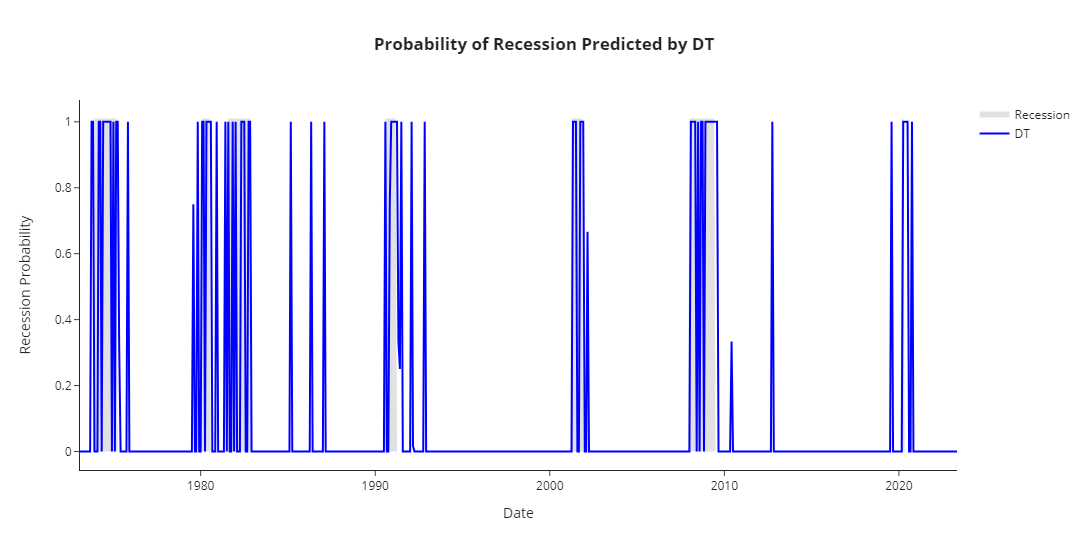

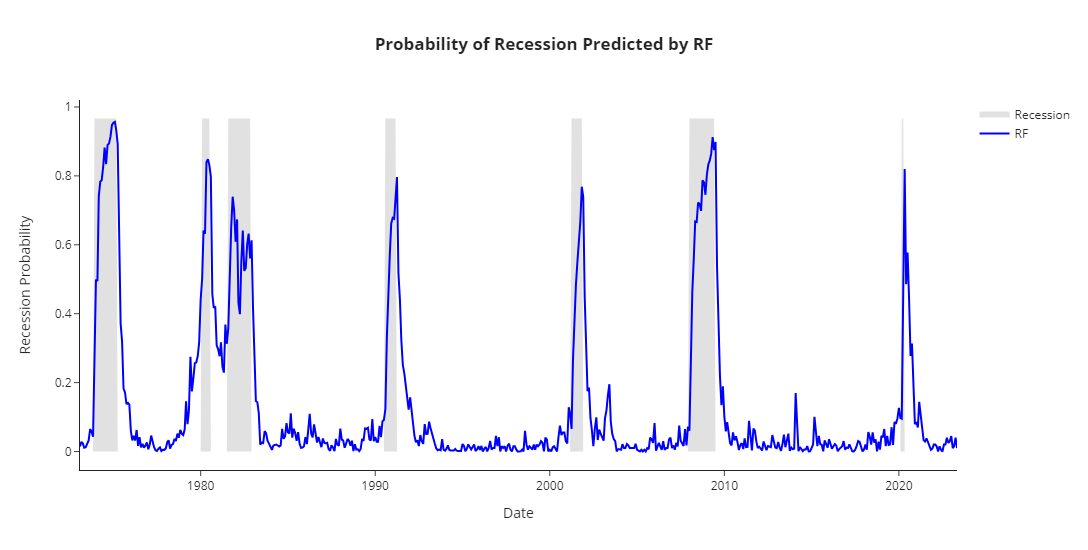

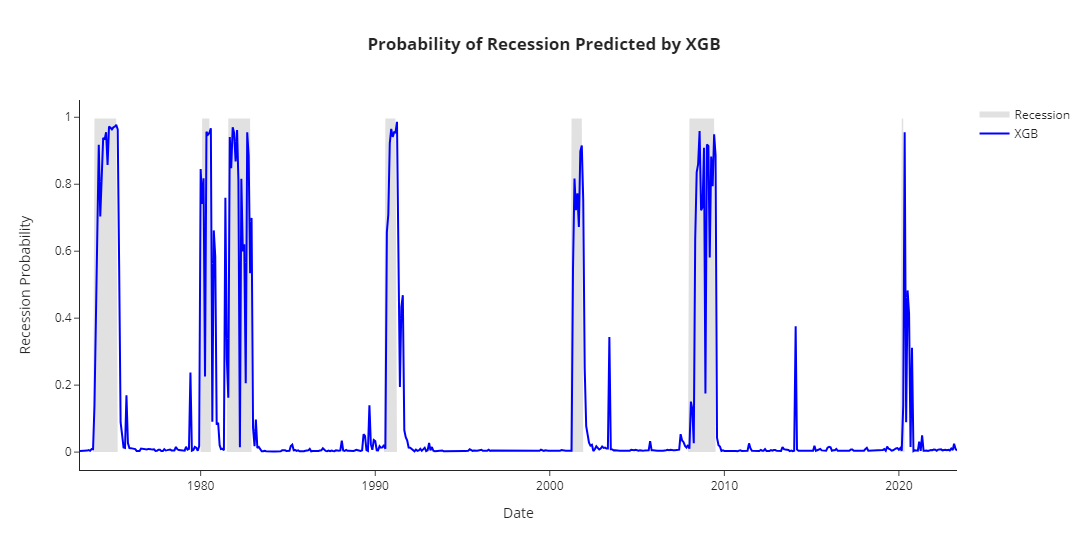

In [9]:
for model in ['DT', 'RF', 'XGB']:
    fig = plot_regimes(date_series = res_rolling_all['Date'],
                       data_series = res_rolling_all[model], 
                       regime_series = res_rolling_all['Regime'],
                       area_name = 'Recession',
                       data_name = model,
                       x_axis_title = 'Date',
                       y_axis_title = 'Recession Probability',
                       plot_title = f'Probability of Recession Predicted by {model}',
                       log_scale = False)
    fig.show()

### __3.2. Save Models Predictions__ <a id="section32"></a>

Now that we have trained and made predictions for the regimes in the out-of-sample dataset, we will save these predictions for future evaluation and model selection purposes. The saved data includes the date and the true regime, along with the recession probability predicted by each model. This information will be stored in the form of a CSV file.

In [10]:
res_rolling_all.set_index('Date').to_csv(f'../data/predictions/{h}M_econ_preds.csv')

---
## **4. Model Evaluation and Selection** <a id="section4"></a>

### **4.1. Confusion Matrices for Models** <a id="section41"></a>

To delve into the prediction results, we will analyze the confusion matrix for each model. The horizontal axis denotes the predicted class, while the vertical axis signifies the actual class. Based on the confusion matrix, it becomes evident that the random forest model outperforms both the decision tree and XGBoost, exhibiting superior classification capabilities for both normal and recession periods. XGBoost stands as the second best classifier in this context.

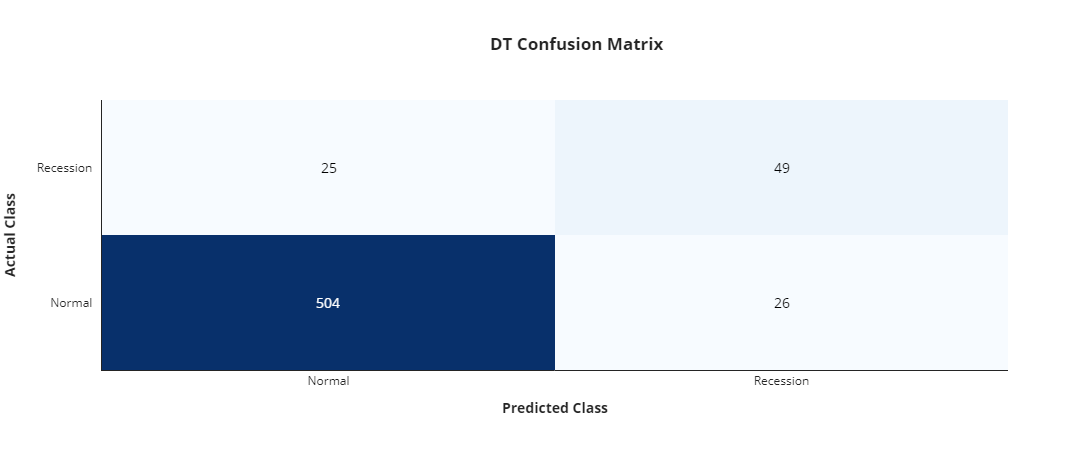

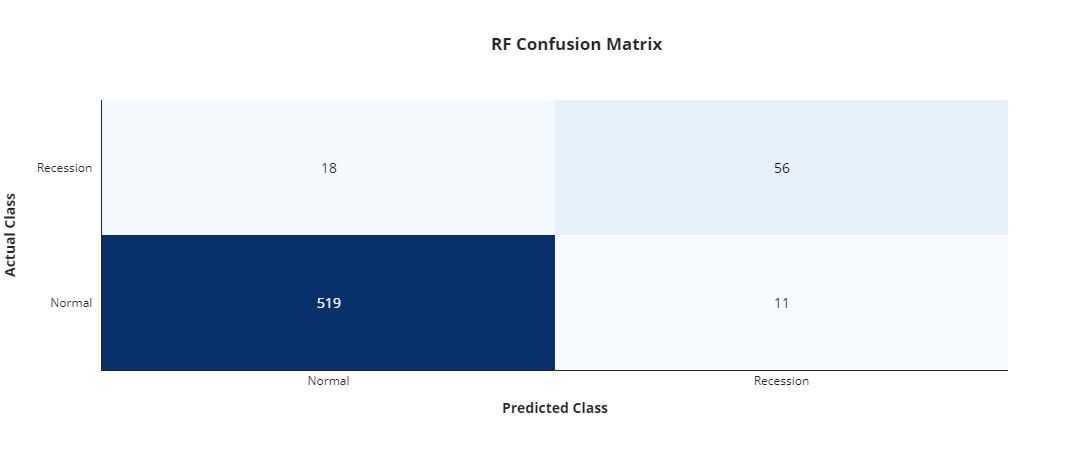

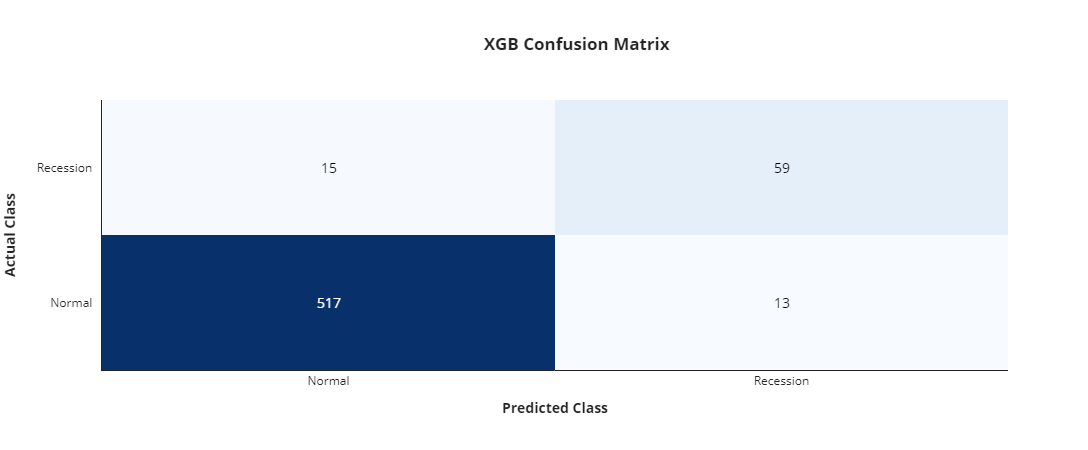

In [11]:
for model in ['DT', 'RF', 'XGB']:
    fig = plot_confusion_matrix(y_true = res_rolling_all['Regime'].values, 
                                y_pred = res_rolling_all[model].apply(lambda x: 1.0 if x>0.5 else 0.0).values, 
                                class_names = ['Normal', 'Recession'], 
                                title = f'{model} Confusion Matrix')
    fig.show()

### **4.2. Evaluation Metrics** <a id="section42"></a>

In this section, our focus shifts towards a detailed examination of various evaluation metrics, including accuracy, balanced accuracy, precision, recall, and the Matthews Correlation Coefficient. To enhance the depth and comprehensiveness of our analysis, we will introduce the ROC-AUC metric into the evaluation framework. The incorporation of ROC-AUC aims to provide a comprehensive and comparative assessment of the models' performance in the realm of recession forecasting.

This comprehensive array of evaluation metrics will play a pivotal role in guiding our decision-making process to identify the optimal model for effectively addressing the inherent challenges of recession prediction. However, prior to delving further into our analysis, we will initiate our exploration by conducting a comprehensive review of each of these evaluation metrics.

* __Accuracy:__ The accuracy metric serves as a fundamental tool for assessing the performance of binary classification models designed to differentiate between normal and recession regimes. This metric quantifies the fraction of accurately predicted instances out of the total, thus offering a comprehensive measure of prediction correctness. Mathematically, accuracy is computed as the ratio of correct predictions to the overall number of predictions made. Nevertheless, it's crucial to acknowledge that accuracy might not provide a comprehensive view of model performance in datasets with imbalanced class distribution—similar to the scenario we encounter in our problem. In such cases, where one class is significantly more prevalent than the other, relying solely on accuracy can be misleading. Therefore, supplementary metrics like precision, recall, and F1-score are valuable for gaining a more nuanced understanding of the model's effectiveness.

$$
\text{Accuracy} = \frac{\text{Number of Correct Predictions}}{\text{Total Number of Predictions}}
$$

* __Balanced Accuracy:__ The balanced accuracy metric holds significant importance in the evaluation of binary classification models tailored to handle imbalanced datasets, such as those involved in distinguishing between normal and recession regimes. It serves as a robust indicator of a model's proficiency in accurately classifying instances across both classes, while also factoring in the inherent class distribution imbalance. From a mathematical standpoint, balanced accuracy is derived by computing the average of sensitivity (true positive rate) for the 'normal' class and specificity (true negative rate) for the 'recession' class. This approach ensures that the assessment considers the unique challenges posed by imbalanced class distributions. By doing so, the balanced accuracy metric delivers a more equitable appraisal of the model's performance, offering insights into its effectiveness in handling both 'normal' and 'recession' predictions. However, it's important to underscore that while balanced accuracy is a valuable tool, a comprehensive evaluation of model performance requires considering it in conjunction with other pivotal metrics such as precision, recall, and F1-score. This multifaceted approach enables us to garner a well-rounded understanding of the model's overall effectiveness in tackling the task at hand.

$$
\text{Balanced Accuracy} = \frac{\text{Sensitivity (TPR)} + \text{Specificity (TNR)}}{2}
$$


* __Precision:__ Precision serves as a pivotal metric in the assessment of binary classification models, particularly when dealing with scenarios like distinguishing between 'normal' (encoded as class 0) and 'recession' (encoded as class 1) regimes. Precision focuses on the model's aptitude for accurately identifying positive instances (in this case, recession) among the instances it predicts as positive. From a mathematical perspective, precision is calculated by determining the ratio of true positive predictions to the total number of positive predictions. This metric offers valuable insights into the model's dependability in making positive predictions and highlights its capacity to minimize false positives. Precision gains even greater significance in situations where false positives carry substantial implications. By examining precision, we gain a deeper understanding of the model's precision in its positive predictions, thereby assessing its potential to reduce the occurrence of erroneous positive predictions. It's important to emphasize that the evaluation of precision is most effective when considered in conjunction with other essential metrics such as recall, F1-score, and balanced accuracy. This holistic approach enables us to acquire a comprehensive grasp of the model's performance across various dimensions.

$$
\text{Precision} = \frac{\text{True Positives}}{\text{True Positives} + \text{False Positives}}
$$



* __Recall:__ Recall, also known as sensitivity or the true positive rate, plays a pivotal role in the evaluation of binary classification models, especially in scenarios involving the differentiation between normal and recession regimes. This metric assesses the model's proficiency in accurately identifying all positive instances, specifically 'recession' instances, among the actual positive instances. Mathematically, recall is computed as the ratio of true positive predictions to the total count of actual positive instances. By doing so, this metric provides valuable insights into the model's sensitivity towards detecting positive cases, thereby highlighting its capability to minimize instances of false negatives. Recall gains heightened significance when the avoidance of false negatives holds paramount importance. This metric serves as a critical tool in ensuring that instances of actual positive cases, particularly 'recession' regimes, are not overlooked. While evaluating recall, it is prudent to consider a comprehensive range of metrics such as precision, F1-score, and balanced accuracy. This multifaceted assessment approach ensures a thorough understanding of the model's performance across various dimensions and aids in making informed decisions regarding its effectiveness.

$$
\text{Recall} = \frac{\text{True Positives}}{\text{True Positives} + \text{False Negatives}}
$$

* __F1-Score:__ The F1-score holds significant importance in evaluating the overall performance of binary classification models, particularly in scenarios where tasks involve differentiating between 'normal' (class 0) and 'recession' (class 1) regimes. This metric strikes a harmonious balance between precision and recall, furnishing a holistic assessment of a model's efficacy in accurately identifying positive instances while minimizing the occurrences of false positives and false negatives. Mathematically, the F1-score is calculated as the harmonic mean of precision and recall. The resulting value of the F1-score ranges between 0 and 1, with higher values indicating superior model performance in achieving an optimal equilibrium between precision and recall. The F1-score proves especially valuable in situations where false positives and false negatives bear equal significance. As such, the F1-score is particularly apt for scenarios where maintaining a balance between both types of errors is crucial. For a comprehensive evaluation of a model's capabilities, it is advisable to assess the F1-score alongside a spectrum of other metrics, including accuracy, balanced accuracy, ROC-AUC, and the Matthews Correlation Coefficient. This multifaceted approach provides a well-rounded understanding of the model's prowess across diverse evaluation criteria, thereby guiding informed decisions about its efficacy.

$$
\text{F1-score} = 2 \times \frac{\text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}}
$$


* __Matthews Correlation Coefficient (MCC):__ The Matthews Correlation Coefficient (MCC) stands as a comprehensive and robust metric tailored for the evaluation of binary classification models, with a particular focus on tasks involving the differentiation between 'normal' (class 0) and 'recession' (class 1) regimes. The MCC offers a holistic assessment that encompasses true positive, true negative, false positive, and false negative predictions, culminating in a nuanced and balanced evaluation of a model's performance. Mathematically, the MCC is calculated through the following formula. The MCC metric exhibits a range spanning from -1 to +1. A score of +1 signifies impeccable classification accuracy, 0 indicates random classification, and -1 denotes a complete divergence between predictions and observed outcomes. Given its inherent capacity to accommodate imbalanced datasets, the MCC delivers a balanced measure of model performance. As such, it emerges as a valuable and insightful metric that should be considered in conjunction with other crucial metrics such as precision, recall, F1-score, and balanced accuracy. This multifaceted approach ensures a comprehensive understanding of the model's capabilities across various assessment criteria, fostering informed decision-making.

$$
\text{MCC} = \frac{TP \times TN - FP \times FN}{\sqrt{(TP + FP) \times (TP + FN) \times (TN + FP) \times (TN + FN)}}
$$


* __ROC-AUC:__ The Receiver Operating Characteristic - Area Under the Curve (ROC-AUC) constitutes a foundational and pivotal metric designed for the assessment of binary classification models. This metric extends its applicability to tasks involving the differentiation between 'normal' and 'recession' regimes. ROC-AUC operates as a quantifier of the model's adeptness in distinguishing between the two classes by plotting the true positive rate (sensitivity) against the false positive rate across varying classification thresholds. Mathematically, ROC-AUC is computed by integrating the ROC curve, which results from the sensitivity and specificity trade-offs across different threshold values. The area under the ROC curve, a numeric value ranging from 0 to 1, furnishes a comprehensive measure of the model's discriminative prowess. A higher ROC-AUC score conveys superior discriminatory power and, consequently, heightened overall model performance. ROC-AUC shines particularly when models are compared concerning their capabilities to make informed decisions across diverse threshold settings. In tandem with metrics such as precision, recall, F1-score, balanced accuracy, and the Matthews Correlation Coefficient, ROC-AUC contributes valuable insights into a model's classification acumen. By incorporating ROC-AUC into our evaluation framework, we gain a deeper understanding of how effectively the models differentiate between 'normal' and 'recession' regimes under varying conditions.


With this overview of metrics, let's examine how the models performed in terms of these evaluation criteria:

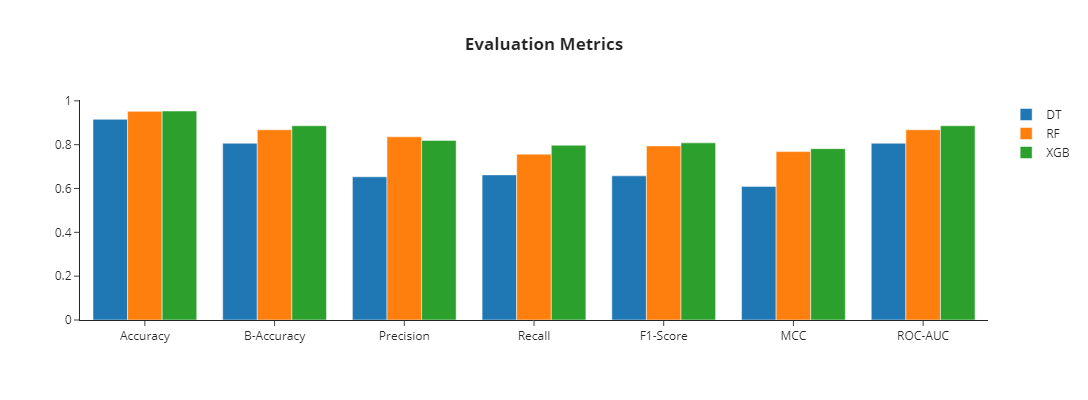

DT        RF       XGB
Accuracy    0.915563  0.951987  0.953642
B-Accuracy  0.806553  0.868001  0.886384
Precision   0.653333  0.835821  0.819444
Recall      0.662162  0.756757  0.797297
F1-Score    0.657718  0.794326  0.808219
MCC         0.609580  0.768437  0.781954
ROC-AUC     0.806553  0.868001  0.886384

In [12]:
metrics_result, fig = evaluation_metrics(pred_df = res_rolling_all, 
                                         model_cols = ['DT', 'RF', 'XGB'],
                                         y_true_col = 'Regime')
metrics_result

### __4.3. Model Selection__ <a id="section44"></a>

In this pivotal phase of our analysis, we delve into an exhaustive assessment of three prominent models: Decision Tree (DT), Random Forest (RF), and XGBoost (XGB). Our primary aim is to systematically evaluate their performance across a range of critical evaluation metrics, with a specific focus on addressing the challenges posed by an imbalanced dataset. With the positive class (recession) accounting for just 12% of observations, our scrutiny is tailored to select the most suitable model that can effectively discern between normal and recession regimes.

**Addressing Imbalanced Data**

The economic forecasting task at hand is inherently plagued by a class imbalance, where the minority class (recession) is substantially outnumbered by the majority class (normal regime). In such contexts, traditional metrics like Accuracy may not provide a comprehensive assessment, as a model might achieve high accuracy by predominantly predicting the majority class. To ensure robust evaluation, we emphasize metrics that offer insights into the model's performance across both positive and negative instances.

**Comprehensive Performance Evaluation**

The detailed evaluation table presents a comprehensive view of each model's performance across a spectrum of evaluation metrics. Particularly noteworthy are metrics that provide nuanced insights into model behavior within an imbalanced setting:

| Metric       | DT       | RF       | XGB      |
|--------------|----------|----------|----------|
| **Accuracy** | 0.928808 | 0.951987 | **0.953642** |
| **B-Accuracy** | 0.843167 | 0.868001 | **0.886384** |
| **Precision** | 0.701299 | **0.835821** | 0.819444 |
| **Recall**    | 0.729730 | 0.756757 | **0.797297** |
| **F1-Score**  | 0.715232 | 0.794326 | **0.808219** |
| **MCC**       | 0.674743 | 0.768437 | **0.781954** |
| **ROC-AUC**   | 0.843167 | 0.868001 | **0.886384** |

**Advantages of XGBoost in Handling Imbalanced Data**

The superior performance of the XGBoost model in these pivotal metrics can be attributed to its inherent ability to tackle imbalanced datasets. The utilization of boosting techniques within XGBoost places enhanced focus on the minority class, thereby augmenting its capability to accurately predict instances of recession.

**Definitive Model Selection**

The compelling evidence furnished by these metrics incontrovertibly endorses the **XGBoost (XGB) model** as the prime contender for our forecasting undertaking. Its consistent and balanced performance, particularly in the context of an imbalanced dataset, attests to its adeptness in distinguishing between normal and recession regimes. By opting for the XGBoost model, we equip ourselves with a powerful tool adept at managing imbalanced data, thus elevating the precision and reliability of our economic predictions.

Our commitment to a rigorous, data-driven approach ensures that the XGBoost model emerges as our preferred choice, poised to navigate the intricacies of economic forecasting with utmost accuracy, dependability, and insightfulness.


---

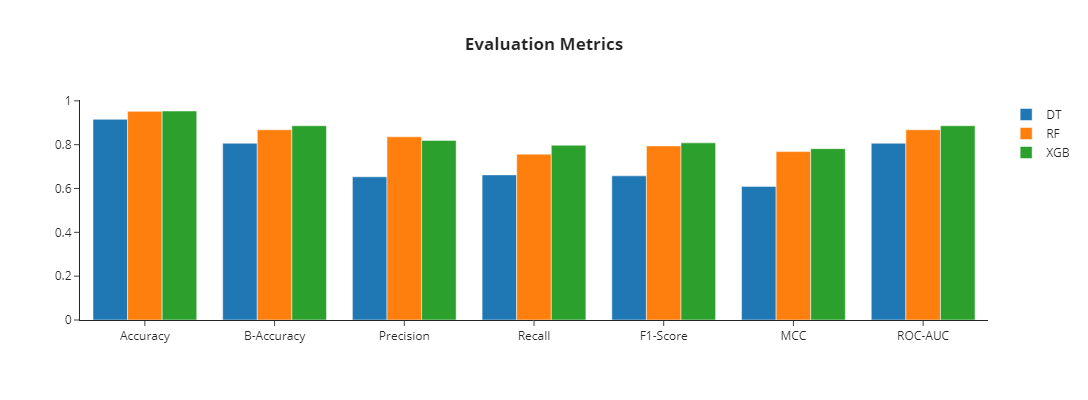

DT        RF       XGB
Accuracy    0.915563  0.951987  0.953642
B-Accuracy  0.806553  0.868001  0.886384
Precision   0.653333  0.835821  0.819444
Recall      0.662162  0.756757  0.797297
F1-Score    0.657718  0.794326  0.808219
MCC         0.609580  0.768437  0.781954
ROC-AUC     0.806553  0.868001  0.886384

In [13]:
metrics_result, fig = evaluation_metrics(pred_df = res_rolling_all, 
                                         model_cols = ['DT', 'RF', 'XGB'],
                                         y_true_col = 'Regime')
metrics_result

## **6. Model Interpretation** <a id="section6"></a>

### **6.1. Challenges in Interpretation and Proposed Solutions** <a id="section61"></a>

Interpreting the built-in feature importance of the XGBoost model takes on a more intricate nature when working with a rolling window strategy for predictions. While traditional feature importance computations encompass the entirety of the training data, the rolling window methodology involves training the model on smaller subsets for each prediction. Despite this unique challenge, we can extract meaningful insights from feature importance through the adoption of the following strategies:

1. **Aggregated Feature Importance**: Although predictions occur on distinct data subsets, we can aggregate the feature importance scores across all rolling windows. By summing or averaging the importance scores of each feature across all predictions, we gain insights into the consistent contributors to the model's decision-making process. This aggregated feature importance provides a broader understanding of the features that exhibit recurring influence on the model's predictions.

2. **Relative Feature Importance**: Rather than directly comparing importance scores across diverse models, we can emphasize the relative significance of features within each model. For each individual rolling window prediction, we can normalize feature importance scores to ensure they collectively sum up to 1. This normalization facilitates the examination of each feature's proportionate contribution within a specific prediction context. By aggregating these normalized values across all predictions, we discern which features consistently exert a more substantial impact within their corresponding contexts.

3. **Temporal Insights**: Given the temporal nature of time-series data and the rolling window technique, it's worthwhile to investigate the temporal evolution of feature importance. Are there intervals during which specific features gain prominence? Do certain time periods witness fluctuations in a feature's importance? This temporal analysis can yield insightful observations about how the model's reliance on specific features evolves over changing economic conditions.

4. **Model Stability**: Although feature importance scores may vary across individual predictions, we can assess the stability of these scores across multiple rolling windows. If the importance scores exhibit consistent patterns across various windows, it indicates that certain features remain influential irrespective of the window's starting point.

In summary, while the rolling window approach introduces complexity to feature importance interpretation, we can extract valuable insights by aggregating, normalizing, and analyzing importance scores across distinct windows. These insights, combined with domain knowledge and complementary interpretability techniques, empower us to comprehend how the XGBoost model generates predictions within the context of our economic forecasting endeavor.

Throughout this documentation, we will primarily adhere to the first approach. However, **feel free to explore the other strategies if you're inclined to delve deeper into the interpretation process**.

### **6.2. Aggregated Feature Importance** <a id="section62"></a>

In this section we will train the XGB models using rolling window, as we did in out of sample prediction. for each model, we will calculate feature importance of the model and aggregate these data into a dataframe for further analysis. 

In [14]:
%%time

# Set the rolling window size for training on out-of-sample data
roll_window = 150

# Find the starting index location of the out-of-sample data
oos_start_index = econ_regs_ds[econ_regs_ds['Date'] == split_date].index.tolist()[0]

# Slice the df_pred from the original dataset, starting from oos_start_index minus the rolling window size
df_pred = econ_regs_ds.iloc[oos_start_index - roll_window:, :]
X = df_pred[feature_cols]
y = df_pred[target_col]
date_range = df_pred['Date']

# Load the XGBoost model hyperparameters
xgb_params = best_params_dict[('XGB', xgb.XGBClassifier)]

# Initialize a list to store dictionaries containing feature importance scores for each prediction
feature_importance_list = []

# Loop over df_pred (out-of-sample data), fit and predict using XGBoost model
for i in np.arange(0, len(df_pred) - roll_window):

    # Initialize an XGBoost model for each iteration
    xgb_model = xgb.XGBClassifier(**xgb_params)
    
    # Fit the XGBoost model using the rolling training window's data
    X_fit = X.iloc[i: i + roll_window, :]
    y_fit = y.iloc[i: i + roll_window]
    xgb_model = xgb_model.fit(X_fit, y_fit)

    # Get feature importance scores from the trained model
    importance_scores = xgb_model.feature_importances_
    
    # Get true label and predicted probability for the XGBoost model
    true_label = y.iloc[i + roll_window]
    xgb_prob = xgb_model.predict_proba(X.iloc[i + roll_window: i + roll_window + 1, :])[:, 1][0]
    
    # Create a dictionary to store feature importance and other information
    feature_importance_dict = {'Date': date_range.iloc[i + roll_window],
                               'Regime': true_label,
                               'Pred_Prob': xgb_prob}
    
    # Add feature importance scores to the dictionary
    for j, feature in enumerate(feature_cols):
        feature_importance_dict[feature] = importance_scores[j]
    
    # Append the dictionary to the list
    feature_importance_list.append(feature_importance_dict)

# Create a dataframe from the list of dictionaries
feature_importance_df = pd.DataFrame(feature_importance_list)

Wall time: 5min 47s


Next, we will compute the **average importance of features across all predictions** and **add the group name** to the data:

In [15]:
# Calculate average feature importance by mean across predictions
avg_feat_impo = pd.DataFrame(feature_importance_df[feature_cols].mean()).reset_index()
avg_feat_impo.columns = ['Feature', 'AvgImportance']
avg_feat_impo.sort_values('AvgImportance', ascending=False, inplace=True)

# Load feature specification data and remove "nM Lag" texts from feature names
feat_spec_df = pd.read_csv('../data/raw_data/fredmd_feat_spec.csv', index_col='ID')[['Feature', 'Group']]
remove_texts = ['1M Lag', '3M Lag', '6M Lag', '9M Lag', '12M Lag']
avg_feat_impo['CleanFeature'] = avg_feat_impo['Feature'].str.replace('|'.join(remove_texts), '', regex=True).str.strip()

# Merge dataframes and clean columns
avg_feat_impo = avg_feat_impo.merge(feat_spec_df, left_on='CleanFeature', right_on='Feature', how='left').dropna()
avg_feat_impo = avg_feat_impo[['Feature_x', 'Group', 'AvgImportance']]
avg_feat_impo.columns = ['Feature', 'Group', 'Importance']
avg_feat_impo.set_index('Feature')

Group  Importance
Feature                                                           
CPIMEDSL 3M Lag                                 Prices    0.049318
T1YFFM 12M Lag             Interest and Exchange Rates    0.049055
BAAFFM 6M Lag              Interest and Exchange Rates    0.043002
HOUSTW                                         Housing    0.042334
IPMANSICS                            Output and Income    0.039006
...                                                ...         ...
CONSPI 3M Lag                         Money and Credit    0.000000
RETAILx 6M Lag     Consumption, Orders and Inventories    0.000000
WPSFD49502 1M Lag                               Prices    0.000000
UEMPMEAN 12M Lag                          Labor Market    0.000000
TOTRESNS 6M Lag                       Money and Credit    0.000000

[696 rows x 2 columns]

Now, we'll group features within the same category and sum up their individual importances to calculate the **importance for each group**:

In [16]:
# Calculate group importance
avg_group_impo = avg_feat_impo.groupby('Group')['Importance'].sum().reset_index()
avg_group_impo.sort_values(by='Importance', ascending=False, inplace=True) 
avg_group_impo.set_index('Group')

Importance
Group                                          
Interest and Exchange Rates            0.405001
Labor Market                           0.164306
Output and Income                      0.132508
Prices                                 0.116093
Housing                                0.098265
Money and Credit                       0.039065
Consumption, Orders and Inventories    0.031595
Stock Market                           0.011363

Lastly, we will utilize the feature and group importance data to generate a visualization, allowing us to comprehend the significant contributions of individual features and groups of features towards predicting both normal and recessionary regimes:

In [17]:
num_features_slider = widgets.IntSlider(value=50, min=50, max=100, step=10, description='<b> Max. Bars</b>')
start_feature_slider = widgets.IntSlider(value=1, min=1, max=200, step=20, description='<b> Start Feat. </b>')
interact(plot_feature_importance, 
         feat_impo_df=widgets.fixed(avg_feat_impo), 
         group_impo_df=widgets.fixed(avg_group_impo),
         plot_title = widgets.fixed('Average Feature and Group Importance for Recession Prediction Model'),
         bar_plot_title = widgets.fixed('Average Feature Importance'),
         pie_plot_title = widgets.fixed('Average Group Importance'),
         start_feat_idx=start_feature_slider, 
         max_feat_no=num_features_slider);

interactive(children=(IntSlider(value=1, description='<b> Start Feat. </b>', max=200, min=1, step=20), IntSlid…

### **6.3. Final Remarks** <a id="section63"></a>

In this section, we emphasize that the provided values signify the average importance of both individual features and groups. It is imperative to acknowledge that the significance levels of these features undergo temporal fluctuations over time. This very reason led us to embrace a rolling window methodology during the model training process. Consequently, for those contemplating the utilization of this pilot project for business endeavors, delving deeper into the interpretation process becomes an imperative step.